In [92]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import sys

In [93]:
N_x = 9
N_y = 10
N_tot = N_x*N_y 
V = 1.
t = -V
U = 4.
D = V
#mu = 0
Doping = 1./9.
print(Doping*N_tot)
n_filling = 1.- Doping#1 for half-filling 
t_prime = 0.0
Periodic_Boundaries = True
TwoBandModel = False
Magnetic_z_bias = False

np.set_printoptions(threshold=sys.maxsize)

10.0


In [94]:
H_0 = np.zeros([2*N_tot,2*N_tot])#Hamiltonian without any Deltas
#GapVector = np.zeros(4*N_tot) #Contains first the n_ups, then n_downs, then Re(d_up d_down), then Im

In [95]:
QuantumNumbers = []  #To write a single index insead of (x,y,s).
for i in range(N_y):
    for j in range(N_x):
        for s in (1,-1):
            QuantumNumbers.append([j,i,s])

In [96]:
H_0 = np.zeros([2*N_tot,2*N_tot],dtype = "complex")  #Fill up H_0 without the Gaps

for i in range(2*N_tot):     
    for j in range(2*N_tot):  
        x1,y1,s1 = QuantumNumbers[i]
        x2,y2,s2 = QuantumNumbers[j]
        
        #Implement Nearest-Neighbour-Hopping:
        if(x1 == x2+1 or x1 == x2-1):
            if(s1 == s2 and y1 == y2):
                H_0[i,j]+= t
        
        if(y1 ==y2+1 or y1 == y2-1):
            if(s1 == s2 and x1 == x2):
                H_0[i,j]+= t
        
        
        #Implement Next-Nearest-Neighbour-Hopping:
        if(x1 == x2+1 or x1 == x2-1):
            if(y1 ==y2+1 or y1 == y2-1):
                if(s1 == s2):
                
                    H_0[i,j]+= t_prime

                
                
        if(Periodic_Boundaries == True): #implement boundaries
            
            #for nearest neighbour hopping
            if(x1 == 0 and x2 == N_x-1):
                if(s1 == s2 and y1 == y2):
                    H_0[i,j]+= t
            if(x2 == 0 and x1 == N_x-1):
                if(s1 == s2 and y1 == y2):
                    H_0[i,j]+= t
            if(y2 == 0 and y1 == N_y-1):
                if(s1 == s2 and x1 == x2):
                    H_0[i,j]+= t
            if(y1 == 0 and y2 == N_y-1):
                if(s1 == s2 and x1 == x2):
                    H_0[i,j]+= t
                    
            #For next nearest neighbour hopping
            if(x1 == 0 and x2 == N_x-1):
                if(y1%N_y ==(y2+1)%N_y or y1%N_y == (y2-1)%N_y): #with modulus to account for corner-corner-hopping
                    if(s1 == s2):
                        H_0[i,j]+= t_prime
            if(x2 == 0 and x1 == N_x-1):
                if(y1%N_y ==(y2+1)%N_y or y1%N_y == (y2-1)%N_y):
                    if(s1 == s2):
                        H_0[i,j]+= t_prime
            if(y2 == 0 and y1 == N_y-1):
                if(x1 == x2+1 or x1 == x2-1):  # Here without the modulus, since else we would double count the corner-corner hopping
                    if(s1 == s2):
                        H_0[i,j]+= t_prime
            if(y1 == 0 and y2 == N_y-1):
                if(x1 == x2+1 or x1 == x2-1):
                    if(s1 == s2):
                        H_0[i,j]+= t_prime
                    
                    
                    
        if(TwoBandModel == True): #implement offset if the atoms are distinct
            if(x1==x2 and y1==y2 and s1 ==s2):
                if((x1%2 == y1%2)):
                    H_0[i,j]+=D
        if(Magnetic_z_bias == True): #apply a tiny magnetic field
            if(x1 ==x2 and y1 == y2):
                if(s1==s2==1):
                    H_0 +=0.0001
            
H_0 = np.array(H_0)

In [97]:
def Get_H(GapVector,H_0): #Returns the full Hamiltonian for a given GapVector
    
    H = np.array(H_0)
    
    N_ups = GapVector[:N_tot]
    N_downs = GapVector[N_tot:2*N_tot]
    Re_up_down = GapVector[2*N_tot:3*N_tot]
    Im_up_down = GapVector[3*N_tot:4*N_tot]
    
    for i in range(2*N_tot):     #Fills up H entrywise
        for j in range(2*N_tot):
            
            x1,y1,s1 = QuantumNumbers[i]
            x2,y2,s2 = QuantumNumbers[j]
            
            SiteIndex = N_x*y1+x1
            
            if(x1 == x2 and y1 == y2):

                if(s1 == s2 ==1):
                    H[i,j] += U*N_downs[SiteIndex]
                if(s1 == s2 ==-1):
                    H[i,j] += U*N_ups[SiteIndex]
                if(s1==1 and s2 ==-1):
                    H[i,j] += U*(-Re_up_down[SiteIndex]+1j*Im_up_down[SiteIndex]) 
                if(s1==-1 and s2 ==1):
                    H[i,j] += U*(-Re_up_down[SiteIndex]-1j*Im_up_down[SiteIndex]) 
                    
    return np.array(H)

In [98]:
def Exp_Val(g,g_prime,Matrix):
    N_filled = int(N_tot*n_filling)
    Exp = 0.
    for i in range(N_filled):
        Exp += Matrix[g,i].conjugate()*Matrix[g_prime,i]
    return Exp
    

In [99]:
def Next_Gap_Vector(GapVector,GetEnergy=False):
    H = Get_H(GapVector,H_0)
    epsilons, Matrix = np.linalg.eigh(H)
    #epsilons = np.diag(epsilons)
    N_ups_new = []
    N_downs_new = []
    Re_UpDown = []
    Im_UpDown = []
    for i in range(N_tot):
        N_ups_new.append(np.real(Exp_Val(2*i,2*i,Matrix)))
        N_downs_new.append(np.real(Exp_Val(2*i+1,2*i+1,Matrix)))
        D_up_down = Exp_Val(2*i,2*i+1,Matrix)
        Re_UpDown.append(np.real(D_up_down))
        Im_UpDown.append(np.imag(D_up_down))
    NewGapVector = np.append(N_ups_new,np.append(N_downs_new,np.append(Re_UpDown,Im_UpDown)))
    
    if(GetEnergy == True):
        N_ups = GapVector[:N_tot]
        N_downs = GapVector[N_tot:2*N_tot]
        D_UpDowns = GapVector[2*N_tot:3*N_tot] + 1j*GapVector[3*N_tot:]
        Energy = sum(epsilons[:int(N_tot*n_filling)]) - U*sum(N_ups*N_downs) -U*sum(np.abs(D_UpDowns)**2)
        return Energy / int(N_tot*n_filling)
    return NewGapVector

In [178]:
RandVec = np.random.random(N_tot)/10
GapVector = 10*np.append(RandVec,np.append(RandVec,np.random.random(2*N_tot)-0.5))


0
0.858986762550647
0.12074732627919754 -1.8967059396021135 0.3753989216661624


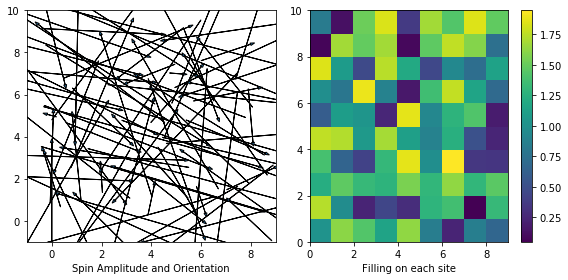

20
-0.9775715328018371
1.1188276603090934 -1.0734831766492148 0.9462480911165914


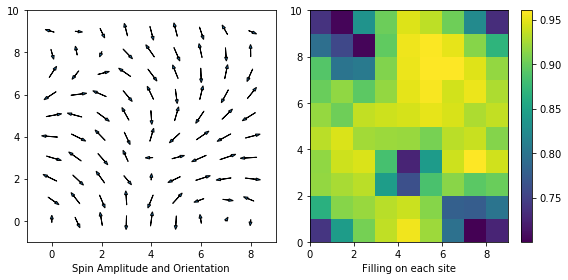

100
-0.9424091141245164
1.0007945663338706 -0.9999295197015698 0.999978566142254


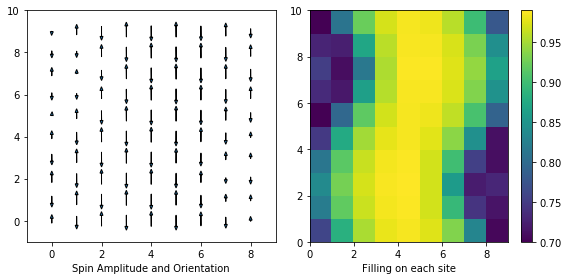

200
-0.9415004113710878
1.0000002689775138 -0.999999937578133 1.0000000466434378


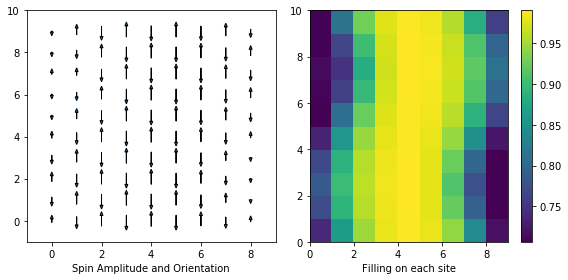

300
-0.9415001677326734
0.9999999999879577 -0.9999999999509983 1.0000000000925906


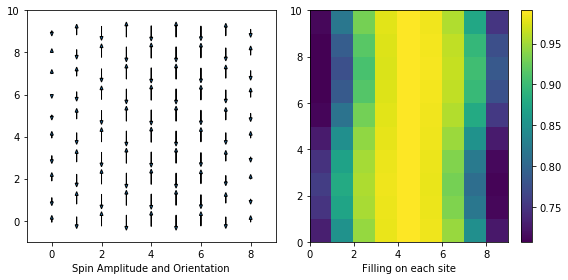

400
-0.941500167795657
0.9999999999998612 -0.9999999999999424 1.0000000000001328


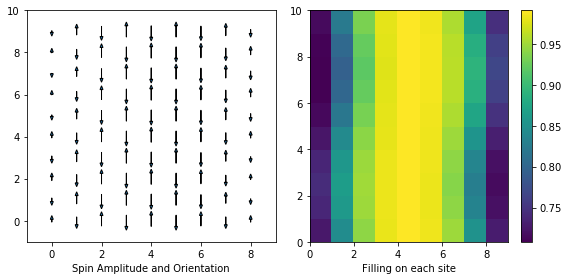

500
-0.9415001677958538
0.9999999999999999 -1.0 1.0000000000000004


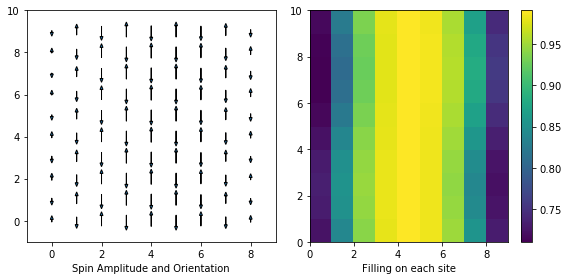

600
-0.9415001677958541
1.0000000000000002 -1.0 0.9999999999999999


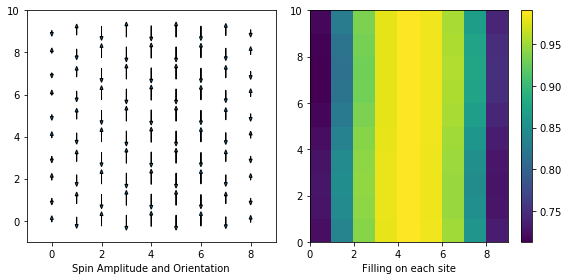

700
-0.9415001677958541
1.0000000000000002 -1.0000000000000002 1.0000000000000002


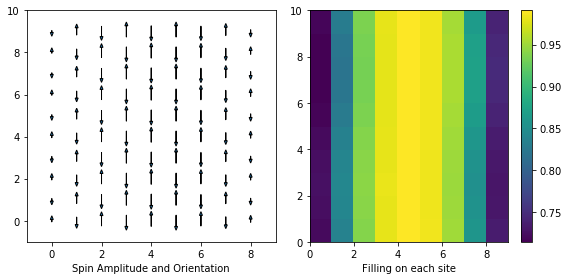

800
-0.9415001677958541
1.0000000000000002 -1.0000000000000002 1.0


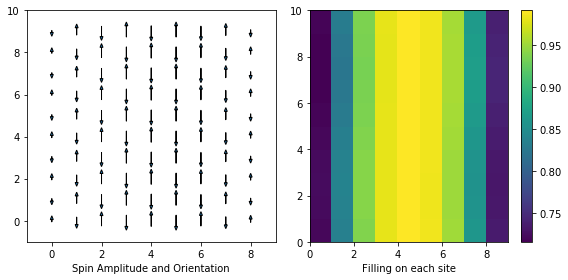

KeyboardInterrupt: 

In [179]:
for i in range(6000):
    if(i%100 == 0 or i == 20):
        print(i)
        Plot_Arrows(GapVector)

    GapVector = 0.1*GapVector + 0.9*Next_Gap_Vector(GapVector) 


In [ ]:
print(i)
print(GapVector[:10],GapVector[N_tot:N_tot+10])
GapVector2 = Next_Gap_Vector(GapVector)
print(GapVector[:10],GapVector[N_tot:N_tot+10])
print(min(GapVector2 - GapVector))


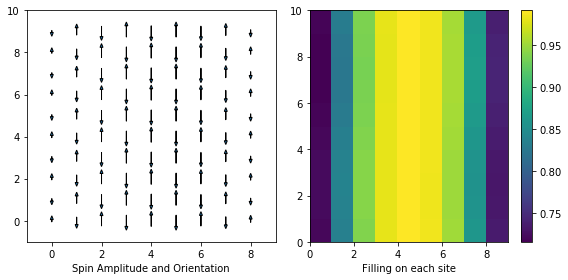

In [180]:
def Plot_Arrows(GapVector):
    N_ups = GapVector[:N_tot]
    N_downs = GapVector[N_tot:2*N_tot]
    D_UpDowns = GapVector[2*N_tot:3*N_tot] + 1j*GapVector[3*N_tot:]


    Pol = N_ups-N_downs
    Pol = Pol.reshape(N_y,N_x)
    Filling = N_ups+N_downs
    Filling = Filling.reshape(N_y,N_x)

    N_is = N_ups+N_downs
    Phi_is = np.angle(D_UpDowns)
    M_is = np.sqrt((N_ups-N_downs)**2+4*np.abs(D_UpDowns)**2)
    Theta_is = np.arccos((N_ups-N_downs)/M_is)

    M_is = M_is.reshape(N_y,N_x)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

    for i in range(N_x):
        for j in range(N_y):

            Angle = Phi_is[N_x*j+i]-Phi_is[0] +np.pi/2
            dx = 0.8*M_is.flatten()[N_x*j+i]*np.cos(Angle)
            dy = 0.8*M_is.flatten()[N_x*j+i]*np.sin(Angle)
            axes[0].arrow(i-dx/2,j-dy/2,dx,dy,head_width = 0.12)
    axes[0].set_xlabel("Spin Amplitude and Orientation")
    axes[0].set_xlim(-1,N_x)
    axes[0].set_ylim(-1,N_y)

    #print(Phi_is[0]/np.pi)
    #print((Phi_is[1]-Phi_is[0])/(np.pi),(Phi_is[2]-Phi_is[1])/(np.pi),(Phi_is[3]-Phi_is[2])/(np.pi))


    im = axes[1].pcolormesh(Filling)
    axes[1].set_xlabel("Filling on each site")
    fig.tight_layout()
    #cax = fig.add_axes([0.99, 0.15, 0.02, 0.8])
    fig.colorbar(im,orientation='vertical')
    
    ###plt.savefig("N_18_20_U4_1over9Doping.pdf",format="pdf")
    plt.show()

Plot_Arrows(GapVector)

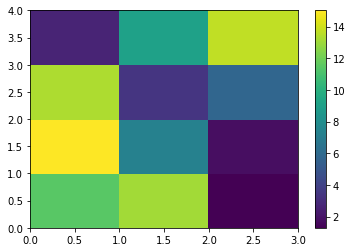

In [104]:
plt.pcolormesh(Filling)
plt.colorbar()
plt.show()


In [105]:
for Index in [2]:
    Shift_x = -4
    Shift_y = 9

    Filling_Shifted = np.zeros([N_x,N_y])
    for i in range(N_x):
        for j in range(N_y):
            Filling_Shifted[i,j] = Filling[(i+Shift_y)%N_y,(j+Shift_x)%N_x]

    plt.pcolormesh(Filling_Shifted)
    plt.colorbar()
    plt.show()

IndexError: index 9 is out of bounds for axis 0 with size 4

In [ ]:
print(N_is[13])
print(N_is.reshape(N_x,N_y)[1,3])

In [91]:
np.save("ToBeTransferred/GapVector_Nx{}_Ny{}_U{}_Doping{}_OneBandModel_Iteration{}_tprime{}.npy".format(N_x,N_y,int(U),Doping,2000,np.abs(t_prime)),GapVector)